## Group 13 - Nishchal Mishra ; Unsupervised content based clustering of New York Times articles.

In [0]:
from datetime import datetime
import numpy as np
import re
import string
import codecs
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import Word2Vec
import matplotlib.pyplot as plt

In [0]:
ss = SparkSession.builder.getOrCreate()

## Input Data From MongoDB

In [0]:
database = 'test_db'
collection = 'new_collection'
user_name = 'chuang86'
password = 'msds697'
address = 'msds697-cluster.sig8e.mongodb.net'
connection_string = f"mongodb+srv://{user_name}:{password}@{address}/{database}.{collection}"

In [0]:
df = spark.read.format("mongo").option("uri",connection_string).load()

In [0]:
df.printSchema()

root
-- 100: struct (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- onsale: string (nullable = true)
 |-- language: string (nullable = true)
 |-- praises: struct (nullable = true)
 | |-- 9780345326492: string (nullable = true)
 |-- authorBio: string (nullable = true)
 |-- aboutTheBook: string (nullable = true)
 |-- keynote: null (nullable = true)
 |-- categories: array (nullable = true)
 | |-- element: struct (containsNull = true)
 | | |-- 2000000111: string (nullable = true)
 | | |-- 2000000133: string (nullable = true)
 | | |-- 2000000136: string (nullable = true)
 | | |-- 2000001111: string (nullable = true)
 | | |-- 2000001114: string (nullable = true)
 | | |-- 2000001121: string (nullable = true)
 | | |-- 2000001123: string (nullable = true)
 | | |-- 2000001191: string (nullable = true)
 | | |-- 2049: string (nullable = true)
 | | |-- 28: string (nullable = true)
-- 1000: struct (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- onsale: string (nullable = true)
 |-- language: string (nullable = true)
 |-- praises: struct (nullable = true)
 | |-- 9780553589399: string (nullable = true)
 | |-- 9780440337584: string (nullable = true)
 |-- authorBio: string (nullable = true)
 |-- aboutTheBook: string (nullable = true)
 |-- keynote: string (nullable = true)
 |-- categories: array (nullable = true)
 | |-- element: struct (containsNull = true)
 | | |-- 2000000054: string (nullable = true)
 | | |-- 2000000057: string (nullable = true)
 | | |-- 2000000113: string (nullable = true)
 | | |-- 2000000114: string (nullable = true)
 | | |-- 2000000131: string (nullable = true)
 | | |-- 2000001130: string (nullable = true)
 | | |-- 2000001137: string (nullable = true)
 | | |-- 2000001139: string (nullable = true)
 | | |-- 2000070001: string (nullable = true)
 | | |-- 2000070071: string (nullable = true)
-- 1001: struct (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- onsale: string (nullable = true)
 |-- language: string (nullable = true)
 |-- praises: struct (nullable = true)
 | |-- 9780440244448: string (nullable = true)
 | |-- 9780440337461: string (nullable = true)
 |-- authorBio: string (nullable = true)
 |-- aboutTheBook: string (nullable = true)
 |-- keynote: string (nullable = true)
 |-- categories: array (nullable = true)
 | |-- element: struct (containsNull = true)
 | | |-- 2000000054: string (nullable = true)
 | | |-- 2000000057: string (nullable = true)
 | | |-- 2000000113: string (nullable = true)
 | | |-- 2000000114: string (nullable = true)
 | | |-- 2000000131: string (nullable = true)
 | | |-- 2000001130: string (nullable = true)
 | | |-- 2000001137: string (nullable = true)
 | | |-- 2000001139: string (nullable = true)
 | | |-- 2000070001: string (nullable = true)
 | | |-- 2000070071: string (nullable = true)
-- 1002: struct (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- onsale: string (nullable = true)
 |-- language: string (nullable = true)
 |-- praises: struct (nullable = true)
 | |-- 9780440245261: string (nullable = true)
 | |-- 9780440339199: string (nullable = true)
 |-- authorBio: string (nullable = true)
 |-- aboutTheBook: string (nullable = true)
 |-- keynote: string (nullable = true)
 |-- categories: array (nullable = true)
 | |-- element: struct (containsNull = true)
 | | |-- 2000000054: string (nullable = true)
 | | |-- 2000000057: string (nullable = true)
 | | |-- 2000000113: string (nullable = true)
 | | |-- 2000000114: string (nullable = true)
 | | |-- 2000000131: string (nullable = true)
 | | |-- 2000001130: string (nullable = true)
 | | |-- 2000001137: string (nullable = true)
 | | |-- 2000001139: string (nullable = true)
 | | |-- 2000070001: string (nullable = true)
 | | |-- 2000070071: string (nullable = true)
-- 1003: struct (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullabl

### Extracting the New York Times data from our collection of all 3 APIs.

In [0]:
from pyspark.sql.functions import col

df_nyt = df.select(col('nytimes6000').getItem(0).alias('nytimes_array')).selectExpr('explode(nytimes_array) as nytimes_struct')

# access the title, caption, and abstract columns
df_nyt = df_nyt.select(col('nytimes_struct')['title'].alias('title'), col('nytimes_struct')['caption'].alias('caption'), col('nytimes_struct')['abstract'].alias('abstract'))
df_nyt.show()


+--------------------+--------------------+--------------------+
 title| caption| abstract|
+--------------------+--------------------+--------------------+
Histories of Hoov...|The winners of th...|The award, one of...|
 The Patriarchy Trap|People gathered i...|Happy Internation...|
‘The Mandalorian’...|One of the great ...|Din and Grogu tak...|
A wide range of p...| |The new intellige...|
Here’s What the F...|Jerome H. Powell,...|Jerome H. Powell,...|
Greece Will Make ...|Workers removing ...|He also apologize...|
Justice Dept. Fin...|A memorial to Bre...|The review, under...|
How to Change Up ...| |If playing the sa...|
Georgian protests...|Protesters outsid...| |
Lacking the firep...|Director of Natio...| |
Memphis to Releas...|A memorial for Ty...|The city will pos...|
When Trump Passes...|Some of former Pr...|Unlike other rece...|
Our Family Keeps ...| |The magazine’s Et...|
E.U. defense mini...|A Ukrainian artil...| |
5 Times Tucker Ca...|Tucker Carlson in...|The Fox host’s pr...|
New Room-Temperat...|A diamond inside ...|The breakthrough ...|
The Wonders of Pa...| |Take the classic ...|
Job Openings Fell...|Openings in const...|The monthly data ...|
Kidnapping in Mex...|A patient from th...|Here’s what exper...|
Watch Scenes From...|Clockwise from to...|Inventive and sur...|
+--------------------+--------------------+--------------------+
only showing top 20 rows

### Declaring a function to convert all strings into arrays by trimming punctuations and stop words, then applying that function as udf on our data.

In [0]:
ENGLISH_STOP_WORDS = frozenset([
	"a", "about", "above", "across", "after", "afterwards", "again", "against",
	"all", "almost", "alone", "along", "already", "also", "although", "always",
	"am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
	"any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
	"around", "as", "at", "back", "be", "became", "because", "become",
	"becomes", "becoming", "been", "before", "beforehand", "behind", "being",
	"below", "beside", "besides", "between", "beyond", "bill", "both",
	"bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
	"could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
	"down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
	"elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
	"everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
	"find", "fire", "first", "five", "for", "former", "formerly", "forty",
	"found", "four", "from", "front", "full", "further", "get", "give", "go",
	"had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
	"hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
	"how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
	"interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
	"latterly", "least", "less", "ltd", "made", "many", "may", "me",
	"meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
	"move", "much", "must", "my", "myself", "name", "namely", "neither",
	"never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
	"nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
	"once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
	"ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
	"please", "put", "rather", "re", "same", "see", "seem", "seemed",
	"seeming", "seems", "serious", "several", "she", "should", "show", "side",
	"since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
	"something", "sometime", "sometimes", "somewhere", "still", "such",
	"system", "take", "ten", "than", "that", "the", "their", "them",
	"themselves", "then", "thence", "there", "thereafter", "thereby",
	"therefore", "therein", "thereupon", "these", "they", "thick", "thin",
	"third", "this", "those", "though", "three", "through", "throughout",
	"thru", "thus", "to", "together", "too", "top", "toward", "towards",
	"twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
	"very", "via", "was", "we", "well", "were", "what", "whatever", "when",
	"whence", "whenever", "where", "whereafter", "whereas", "whereby",
	"wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
	"who", "whoever", "whole", "whom", "whose", "why", "will", "with",
	"within", "without", "would", "yet", "you", "your", "yours", "yourself",
	"yourselves"])

def words(text):
	text = text.lower()
	re_exp = re.compile('[' + string.punctuation + '0-9\\r\\t\\n]')
	re_text = re_exp.sub(' ', text)
	re_exp = re.compile("([\w]*\w)")
	tokens = re_exp.findall(re_text)
	tokens = [w for w in tokens if len(w) >= 3]
	tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]
	return tokens

In [0]:
random_udf = udf(words, ArrayType(StringType()))

for column in ['title', 'caption', 'abstract']:
    df_nyt = df_nyt.withColumn(column+'_vec', random_udf(column))
    df_nyt.show()

+--------------------+--------------------+--------------------+--------------------+
 title| caption| abstract| title_vec|
+--------------------+--------------------+--------------------+--------------------+
Histories of Hoov...|The winners of th...|The award, one of...|[histories, hoove...|
 The Patriarchy Trap|People gathered i...|Happy Internation...| [patriarchy, trap]|
‘The Mandalorian’...|One of the great ...|Din and Grogu tak...|[mandalorian, sea...|
A wide range of p...| |The new intellige...|[wide, range, pro...|
Here’s What the F...|Jerome H. Powell,...|Jerome H. Powell,...|[fed, chair, said...|
Greece Will Make ...|Workers removing ...|He also apologize...|[greece, make, tr...|
Justice Dept. Fin...|A memorial to Bre...|The review, under...|[justice, dept, f...|
How to Change Up ...| |If playing the sa...|[change, gameplay...|
Georgian protests...|Protesters outsid...| |[georgian, protes...|
Lacking the firep...|Director of Natio...| |[lacking, firepow...|
Memphis to Releas...|A memorial for Ty...|The city will pos...|[memphis, release...|
When Trump Passes...|Some of former Pr...|Unlike other rece...|[trump, passes, m...|
Our Family Keeps ...| |The magazine’s Et...|[family, keeps, b...|
E.U. defense mini...|A Ukrainian artil...| |[defense, ministe...|
5 Times Tucker Ca...|Tucker Carlson in...|The Fox host’s pr...|[times, tucker, c...|
New Room-Temperat...|A diamond inside ...|The breakthrough ...|[new, room, tempe...|
The Wonders of Pa...| |Take the classic ...|[wonders, pasta, ...|
Job Openings Fell...|Openings in const...|The monthly data ...|[job, openings, f...|
Kidnapping in Mex...|A patient from th...|Here’s what exper...|[kidnapping, mexi...|
Watch Scenes From...|Clockwise from to...|Inventive and sur...|[watch, scenes, b...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 20 rows

+--------------------+--------------------+--------------------+--------------------+--------------------+
 title| caption| abstract| title_vec| caption_vec|
+--------------------+--------------------+--------------------+--------------------+--------------------+
Histories of Hoov...|The winners of th...|The award, one of...|[histories, hoove...|[winners, bancrof...|
 The Patriarchy Trap|People gathered i...|Happy Internation...| [patriarchy, trap]|[people, gathered...|
‘The Mandalorian’...|One of the great ...|Din and Grogu tak...|[mandalorian, sea...|[great, things, g...|
A wide range of p...| |The new intellige...|[wide, range, pro...| []|
Here’s What the F...|Jerome H. Powell,...|Jerome H. Powell,...|[fed, chair, said...|[jerome, powell, ...|
Greece Will Make ...|Workers removing ...|He also apologize...|[greece, make, tr...|[workers, removin...|
Justice Dept. Fin...|A memorial to Bre...|The review, under...|[justice, dept, f...|[memorial, breonn...|
How to Change Up ...| |If playing the sa...|[change, gameplay...| []|
Georgian protests...|Protesters outsid...| |[georgian, protes...|[protesters, outs...|
Lacking the firep...|Director of Natio...| |[lacking, firepow...|[director, nation...|
Memphis to Releas...|A memorial for Ty...|The city will pos...|[memphis, release...|[memorial, tyre, ...|
When Trump Passes...|Some of former Pr...|Unlike other rece...|[trump, passes, m...|[president, donal...|
Our Family Keeps ...| |The magazine’s Et...|[family, keeps, b...| []|
E.U. defense mini...|A Ukrainian artil...| |[defense, ministe...|[ukrainian, artil...|
5 Times Tucker Ca...|Tucker Carlson in...|The Fox host’s pr...|[times, tucker, c...|[tucker, carlson,...|
New Room-Temperat...|A diamond inside ...|The breakthrough ...|[new, room, tempe...|[diamond, inside,...|
The Wonders of Pa...| |Take the classic ...|[wonders, pasta, ...| []|
Job Openings Fell...|Openings in const...|The monthly data ...|[job, openings, f...|[openings, constr...|
Kidnapping in Mex...|A patient from th...|Here’s what exper...|[kidnapping, mexi...|[patient, united,...|
Watch Scenes From...|Clockwise from

## Converting the words to vectors using spark ML's word2Vec library.

In [0]:
for col in ['title_vec', 'caption_vec', 'abstract_vec']:
    word2Vec = Word2Vec(vectorSize=5, minCount=0, inputCol=col, outputCol=col+"_vector")
    model = word2Vec.fit(df_nyt)
    df_nyt = model.transform(df_nyt)

In [0]:
df_nyt = df_nyt.drop('title_vec', 'caption_vec', 'abstract_vec')
df_nyt.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 title| caption| abstract| title_vec_vector| caption_vec_vector| abstract_vec_vector|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
Histories of Hoov...|The winners of th...|The award, one of...|[-0.0140800764784...|[-0.2314047856877...|[0.11842943821102...|
 The Patriarchy Trap|People gathered i...|Happy Internation...|[0.21488535404205...|[0.16269854549318...|[-0.1355202928185...|
‘The Mandalorian’...|One of the great ...|Din and Grogu tak...|[-0.1330284375697...|[-0.1583702233619...|[0.08680777738077...|
A wide range of p...| |The new intellige...|[0.11650650203227...| (5,[],[])|[-0.2330783846286...|
Here’s What the F...|Jerome H. Powell,...|Jerome H. Powell,...|[-0.1264799304306...|[-0.0652085943664...|[-0.1559961271973...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

## Applying Unsupervised K-Means Clustering to cluster the data in 3 steps.

### Applying K-Means on 'titles'

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(10).setSeed(1).setFeaturesCol("title_vec_vector")
model = kmeans.fit(df_nyt)

df_nyt = model.transform(df_nyt)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="title_vec_vector")
silhouette = evaluator.evaluate(df_nyt)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.30415065443389966
Cluster Centers: 
[-0.07698667 -0.60078752 -0.76611364 -0.19046737 -0.15311949]
[0.14358048 0.1143215 0.25475215 0.04580053 0.17121379]
[-0.1899802 -0.06868607 0.05771093 0.14618796 0.03374477]
[ 0.21183102 0.03612216 0.26168498 -0.05716261 0.00676937]
[-0.23133793 0.01466862 -0.16258767 -0.11217239 -0.1580259 ]
[-0.08589911 0.14068688 0.03761081 0.144584 0.0944211 ]
[ 0.06329386 -0.05165197 0.02032992 -0.10745365 -0.03563816]
[ 0.02311281 0.00863017 0.06188467 -0.02388483 0.1694979 ]
[0.06039204 0.05759368 0.03321993 0.06497665 0.00041403]
[ 0.24791974 0.11804057 -0.19942241 0.0901163 0.08008407]

In [0]:
df_nyt=df_nyt.withColumnRenamed('prediction', 'predictions_title')
df_nyt.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
 title| caption| abstract| title_vec_vector| caption_vec_vector| abstract_vec_vector|predictions_title|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
Histories of Hoov...|The winners of th...|The award, one of...|[-0.0140800764784...|[-0.2314047856877...|[0.11842943821102...| 7|
 The Patriarchy Trap|People gathered i...|Happy Internation...|[0.21488535404205...|[0.16269854549318...|[-0.1355202928185...| 3|
‘The Mandalorian’...|One of the great ...|Din and Grogu tak...|[-0.1330284375697...|[-0.1583702233619...|[0.08680777738077...| 5|
A wide range of p...| |The new intellige...|[0.11650650203227...| (5,[],[])|[-0.2330783846286...| 8|
Here’s What the F...|Jerome H. Powell,...|Jerome H. Powell,...|[-0.1264799304306...|[-0.0652085943664...|[-0.1559961271973...| 5|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
only showing top 5 rows

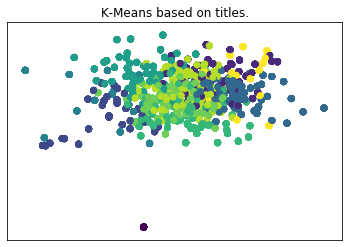

In [0]:
labels = df_nyt.select("predictions_title").rdd.map(lambda row: row[0]).collect()
features = df_nyt.select("title_vec_vector").rdd.map(lambda row: row[0]).collect()

# Create a scatter plot of the data points with color-coded labels
fig, ax = plt.subplots()
ax.scatter([f[0] for f in features], [f[1] for f in features], c=labels)

ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.set_title("K-Means based on titles.")
plt.show()

### Applying K-Means on 'captions'

In [0]:
kmeans = KMeans().setK(10).setSeed(1).setFeaturesCol("caption_vec_vector")
model = kmeans.fit(df_nyt)

df_nyt = model.transform(df_nyt)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="caption_vec_vector")
silhouette = evaluator.evaluate(df_nyt)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.47374982764223306
Cluster Centers: 
[-0.00066493 0.01956542 0.15766687 0.03503338 0.17162784]
[ 0.0010625 -0.00111354 0.00168111 -0.00665565 -0.00179226]
[-0.22549068 -0.04658698 -0.07536715 -0.05960198 0.08505214]
[ 0.47135596 -0.3070654 -0.07937929 0.20912237 -0.59403924]
[-0.06569067 0.14911548 -0.15643857 0.03128501 0.10953394]
[ 0.28687763 0.01763443 0.10360289 -0.13585719 -0.16663517]
[ 0.02612833 0.06949317 0.15701202 0.10056388 -0.1240067 ]
[ 0.0985307 -0.09964266 -0.18611004 0.08600312 -0.11809993]
[-0.18694551 0.02799939 0.12603973 -0.10058318 0.08084996]
[ 0.20024361 -0.10415072 0.02629699 -0.00189123 0.05201642]

In [0]:
df_nyt=df_nyt.withColumnRenamed('prediction', 'predictions_caption')
df_nyt.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+
 title| caption| abstract| title_vec_vector| caption_vec_vector| abstract_vec_vector|predictions_title|predictions_caption|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+
Histories of Hoov...|The winners of th...|The award, one of...|[-0.0140800764784...|[-0.2314047856877...|[0.11842943821102...| 7| 2|
 The Patriarchy Trap|People gathered i...|Happy Internation...|[0.21488535404205...|[0.16269854549318...|[-0.1355202928185...| 3| 9|
‘The Mandalorian’...|One of the great ...|Din and Grogu tak...|[-0.1330284375697...|[-0.1583702233619...|[0.08680777738077...| 5| 2|
A wide range of p...| |The new intellige...|[0.11650650203227...| (5,[],[])|[-0.2330783846286...| 8| 1|
Here’s What the F...|Jerome H. Powell,...|Jerome H. Powell,...|[-0.1264799304306...|[-0.0652085943664...|[-0.1559961271973...| 5| 8|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+
only showing top 5 rows

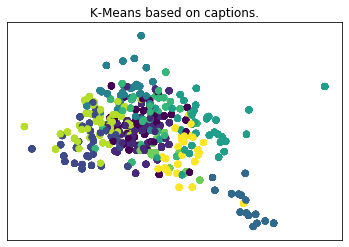

In [0]:
labels = df_nyt.select("predictions_caption").rdd.map(lambda row: row[0]).collect()
features = df_nyt.select("caption_vec_vector").rdd.map(lambda row: row[0]).collect()

# Create a scatter plot of the data points with color-coded labels
fig, ax = plt.subplots()
ax.scatter([f[0] for f in features], [f[1] for f in features], c=labels)

ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.set_title("K-Means based on captions.")
plt.show()

### Applying K-Means on 'abstract'

In [0]:
kmeans = KMeans().setK(10).setSeed(1).setFeaturesCol("abstract_vec_vector")
model = kmeans.fit(df_nyt)

df_nyt = model.transform(df_nyt)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol="abstract_vec_vector")
silhouette = evaluator.evaluate(df_nyt)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.2738793095790776
Cluster Centers: 
[ 0.16157217 -0.03970301 0.07929475 -0.31544537 -0.05435019]
[ 0.02364344 0.0617629 0.0910949 -0.20568564 0.11779166]
[-0.02879868 0.50570464 -0.28713184 0.15037215 0.21706901]
[ 0.06610913 -0.10777691 0.00954302 -0.15379242 0.02115842]
[ 0.03268486 0.0072908 -0.01602346 -0.00039702 -0.02534307]
[ 0.43786668 0.74581551 -0.43742502 0.35380118 0.35340385]
[ 0.1567559 0.13117356 0.07400129 -0.07918642 -0.02889291]
[ 0.01793228 0.05190498 -0.08408508 -0.04315457 0.1448265 ]
[-0.21545017 -0.08785751 0.25381557 0.16949523 0.00550975]
[ 0.12199184 -0.23444491 -0.05160611 -0.24716535 -0.1998583 ]

In [0]:
df_nyt=df_nyt.withColumnRenamed('prediction', 'predictions_abstract')
df_nyt.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+
 title| caption| abstract| title_vec_vector| caption_vec_vector| abstract_vec_vector|predictions_title|predictions_caption|predictions_abstract|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+
Histories of Hoov...|The winners of th...|The award, one of...|[-0.0140800764784...|[-0.2314047856877...|[0.11842943821102...| 7| 2| 4|
 The Patriarchy Trap|People gathered i...|Happy Internation...|[0.21488535404205...|[0.16269854549318...|[-0.1355202928185...| 3| 9| 7|
‘The Mandalorian’...|One of the great ...|Din and Grogu tak...|[-0.1330284375697...|[-0.1583702233619...|[0.08680777738077...| 5| 2| 3|
A wide range of p...| |The new intellige...|[0.11650650203227...| (5,[],[])|[-0.2330783846286...| 8| 1| 8|
Here’s What the F...|Jerome H. Powell,...|Jerome H. Powell,...|[-0.1264799304306...|[-0.0652085943664...|[-0.1559961271973...| 5| 8| 8|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+
only showing top 5 rows

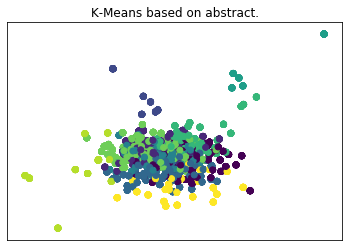

In [0]:
labels = df_nyt.select("predictions_abstract").rdd.map(lambda row: row[0]).collect()
features = df_nyt.select("abstract_vec_vector").rdd.map(lambda row: row[0]).collect()

# Create a scatter plot of the data points with color-coded labels
fig, ax = plt.subplots()
ax.scatter([f[0] for f in features], [f[1] for f in features], c=labels)

ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax.set_title("K-Means based on abstract.")
plt.show()

## Finalizing the Clusters for single document.

In [0]:
def get_prediction(val1, val2, val3):
    return int((val1+val2+val3)/3)

pred_udf = udf(get_prediction, IntegerType())

df_nyt = df_nyt.withColumn('final_predictions', pred_udf('predictions_title', 'predictions_abstract', 'predictions_caption'))
df_nyt.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+-----------------+
 title| caption| abstract| title_vec_vector| caption_vec_vector| abstract_vec_vector|predictions_title|predictions_caption|predictions_abstract|final_predictions|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+-----------------+
Histories of Hoov...|The winners of th...|The award, one of...|[-0.0140800764784...|[-0.2314047856877...|[0.11842943821102...| 7| 2| 4| 4|
 The Patriarchy Trap|People gathered i...|Happy Internation...|[0.21488535404205...|[0.16269854549318...|[-0.1355202928185...| 3| 9| 7| 6|
‘The Mandalorian’...|One of the great ...|Din and Grogu tak...|[-0.1330284375697...|[-0.1583702233619...|[0.08680777738077...| 5| 2| 3| 3|
A wide range of p...| |The new intellige...|[0.11650650203227...| (5,[],[])|[-0.2330783846286...| 8| 1| 8| 5|
Here’s What the F...|Jerome H. Powell,...|Jerome H. Powell,...|[-0.1264799304306...|[-0.0652085943664...|[-0.1559961271973...| 5| 8| 8| 7|
Greece Will Make ...|Workers removing ...|He also apologize...|[0.06479858507269...|[0.21351330385853...|[0.06460945967298...| 1| 5| 4| 3|
Justice Dept. Fin...|A memorial to Bre...|The review, under...|[0.02165091357060...|[-0.1460263711633...|[0.01534405610124...| 6| 0| 3| 3|
How to Change Up ...| |If playing the sa...|[-0.0012131965486...| (5,[],[])|[-0.0960883776553...| 6| 1| 7| 4|
Georgian protests...|Protesters outsid...| |[-0.0092587370115...|[0.12442073294992...| (5,[],[])| 5| 7| 4| 5|
Lacking the firep...|Director of Natio...| |[0.11418483965098...|[0.23797469479697...| (5,[],[])| 8| 9| 4| 7|
Memphis to Releas...|A memorial for Ty...|The city will pos...|[0.14380940888077...|[0.00282195955514...|[0.11962815693446...| 3| 4| 6| 4|
When Trump Passes...|Some of former Pr...|Unlike other rece...|[0.03648509564144...|[-0.1307324011097...|[-2.0535634114192...| 8| 8| 4| 6|
Our Family Keeps ...| |The magazine’s Et...|[0.04327380955219...| (5,[],[])|[0.13886349896589...| 6| 1| 0| 2|
E.U. defense mini...|A Ukrainian artil...| |[-0.0056176481937...|[0.19844172801822...| (5,[],[])| 8| 7| 4| 6|
5 Times Tucker Ca...|Tucker Carlson in...|The Fox host’s pr...|[0.12009217377219...|[0.20969921676442...|[0.05478432937525...| 6| 9| 3| 6|
New Room-Temperat...|A diamond inside ...|The breakthrough ...|[0.09750679507851...|[0.13277449352400...|[0.02680932713805...| 1| 0| 1| 0|
The Wonders of Pa...| |Take the classic ...|[0.05276136007159...| (5,[],[])|[0.16179471425712...| 7| 1| 0| 2|
Job Openings Fell...|Openings in const...|The monthly data ...|[0.16231864743999...|[0.06578122212418...|[0.05150508135557...| 3| 7| 3| 4|
Kidnapping in Mex...|A patient from th...|Here’s what exper...|[0.06077868118882...|[0.06848788706378...|[-0.0853647126091...| 1| 1| 4| 2|
Watch Scenes From...|Clockwise from to...|Inventive and sur...|[-0.1630351647734...|[0.02367121839363...|[-0.0057509298097...| 5| 0| 1| 2|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+-----------------+
only showing top 20 rows

In [0]:
df_ = df_nyt.drop('predictions_title', 'predictions_abstract', 'predictions_caption', 'title_vec_vector', 'caption_vec_vector', 'abstract_vec_vector')
df_.show()

+--------------------+--------------------+--------------------+-----------------+
 title| caption| abstract|final_predictions|
+--------------------+--------------------+--------------------+-----------------+
Histories of Hoov...|The winners of th...|The award, one of...| 4|
 The Patriarchy Trap|People gathered i...|Happy Internation...| 6|
‘The Mandalorian’...|One of the great ...|Din and Grogu tak...| 3|
A wide range of p...| |The new intellige...| 5|
Here’s What the F...|Jerome H. Powell,...|Jerome H. Powell,...| 7|
Greece Will Make ...|Workers removing ...|He also apologize...| 3|
Justice Dept. Fin...|A memorial to Bre...|The review, under...| 3|
How to Change Up ...| |If playing the sa...| 4|
Georgian protests...|Protesters outsid...| | 5|
Lacking the firep...|Director of Natio...| | 7|
Memphis to Releas...|A memorial for Ty...|The city will pos...| 4|
When Trump Passes...|Some of former Pr...|Unlike other rece...| 6|
Our Family Keeps ...| |The magazine’s Et...| 2|
E.U. defense mini...|A Ukrainian artil...| | 6|
5 Times Tucker Ca...|Tucker Carlson in...|The Fox host’s pr...| 6|
New Room-Temperat...|A diamond inside ...|The breakthrough ...| 0|
The Wonders of Pa...| |Take the classic ...| 2|
Job Openings Fell...|Openings in const...|The monthly data ...| 4|
Kidnapping in Mex...|A patient from th...|Here’s what exper...| 2|
Watch Scenes From...|Clockwise from to...|Inventive and sur...| 2|
+--------------------+--------------------+--------------------+-----------------+
only showing top 20 rows

## ML Goal(Nishchal Mishra):
#### To use unsuervised learning on New York Times data and generate cluster labels based on content for future recommendation.
## ML Outcome: 
#### I was successfully able to cluster the articles into 10 clusters based on 'title', 'abstract' and 'caption'.
#### We can use this model to classify any new article by putting them matching their cluster and recommend articles in the same cluster to the user.